In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sgdbandit import environments, agents
import scipy.stats as sps
from experiment_helpers.utils import Experiment
from experiment_helpers import drawer

drawer.FIGSIZE = (7, 3) # to get small figures
drawer.DPI = 100

## Demo one algorithm

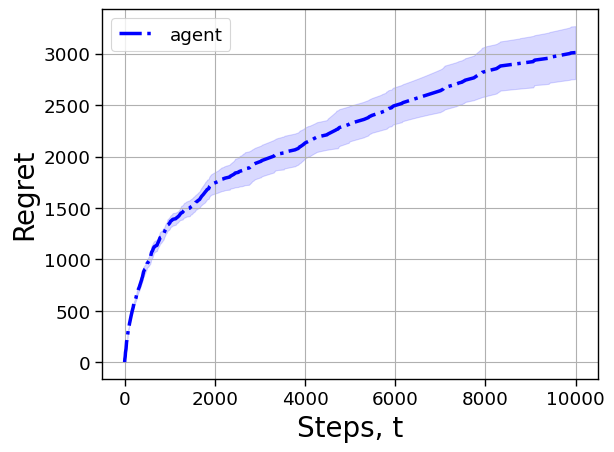

<Figure size 700x300 with 0 Axes>

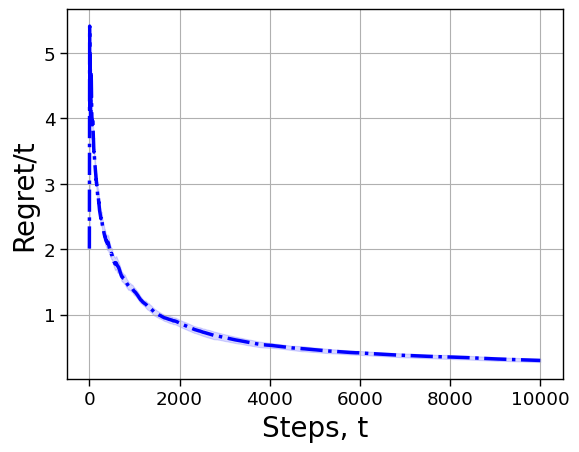

<Figure size 700x300 with 0 Axes>

In [3]:
K = 10_000
trials = 10
n_actions = 20
reward_arr = np.random.rand(n_actions) * 10

env = environments.CauchyDistributionEnv(reward_arr=reward_arr, gamma=1.)

agent = agents.SGD_SMoM(n_actions, coeff = 1, T = K)

regret = [[] for i in range(trials)]
for trial_n in range(trials):
    agent.reset()

    for i in range(K):
        action = agent.get_action()
        reward = env.pull(action)
        agent.update(action,reward)
        regret[trial_n].append(env.optimal_reward() - env.action_reward(action))
        # print(action, end='  ')
regret = {"agent": regret}
_ = drawer.plot(regret_dict=regret)

## Demo many algorithms run

In [4]:

T = 3_000
n_trials = 30 # number of runs for all algorithms

# set ground truth rewards  array

# reward_arr = np.linspace(0, 2, 5)* 2
reward_arr = np.array(list(range(10)))/10
n_actions = len(reward_arr)

# choose the environment ant its parameters:
alpha = 1.25

# env = environments.NormalDistributionEnv(reward_arr=reward_arr)
env = environments.FrechetDistribution(reward_arr=reward_arr, alpha=alpha)
# env = environments.CauchyDistributionEnv(reward_arr=reward_arr, gamma = 1)

30it [00:54,  1.81s/it]


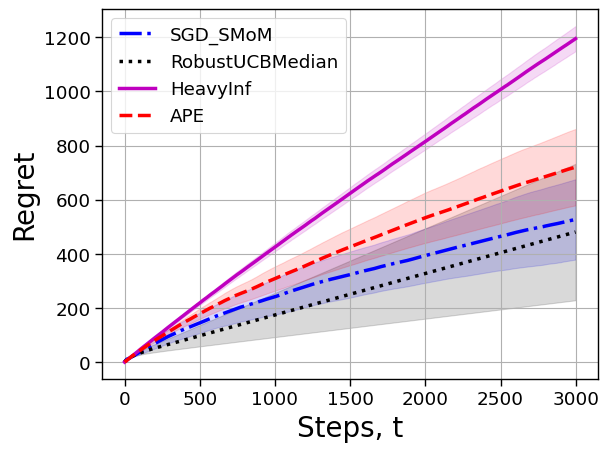

<Figure size 700x300 with 0 Axes>

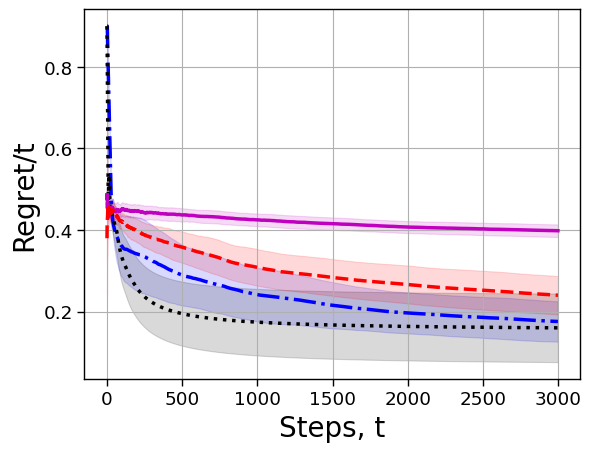

<Figure size 700x300 with 0 Axes>

In [6]:
verbose = False

# parameters for some algorithms:
alpha_alg = 2.
sigma = 40 

agent_list = [
    agents.SGD_SMoM(n_actions, coeff = 0.1, T = T, m = 1, n = 2, init_steps=3),
    # agents.RobustUCBTruncated(n_actions=n_actions, eps = eps, u = 40),
    agents.RobustUCBMedian(n_actions=n_actions, eps = 0., v = np.max(reward_arr)),
    agents.HeavyInf(n_actions, alpha=alpha_alg, sigma=sigma),
    # agents.AdaptiveInf(n_actions, T = T),
    agents.APE(n_actions, 1, alpha_alg, F_inv= lambda x: sps.chi2.ppf(x, df = 1, scale = 2))
]

description = \
    {
    'rewards': reward_arr,
    'n_trials': n_trials,
    'T': T,
}


experiment = Experiment(agent_list=agent_list, 
            environment=env, n_steps=T, n_trials=n_trials,
            name = None, description=description, verbose = verbose)

experiment.run()
experiment.plot()

## Speedtest

the proposed algorithm is computationally efficient, to show this, let's run the algorithms for a time of 1 second and see what step-by-step regrets will be achieved during this time

In [7]:
# https://stackoverflow.com/questions/366682/how-to-limit-execution-time-of-a-function-call
import signal
from contextlib import contextmanager

class TimeoutException(Exception): pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

In [14]:
K = 10_000
trials = 10
n_actions = 20
reward_arr = np.random.rand(n_actions) * 10

# env = environments.FrechetDistribution(reward_arr=reward_arr, alpha=1.3)
env = environments.CauchyDistributionEnv(reward_arr=reward_arr, gamma = 3)

agent_list = [
    agents.SGD_SMoM(n_actions, coeff = 1, T = K),
    agents.RobustUCBTruncated(n_actions=n_actions, u = 4),
    agents.RobustUCBMedian(n_actions=n_actions, v = 5),
    agents.APE(n_actions, c = 0.5, p=2, F_inv= lambda x: sps.chi2.ppf(x, df = 1, scale = 2))    
]
agent_names = [
    'SGD-SMoM',
    'RUCB-Truncated',
    'RUCB-Median',
    ]

for ag, name  in zip(agent_list, agent_names):  # set names for nice plots
    ag.name = name

In [15]:
def run(agent, env):
    steps = 0
    agent.reset()
    regret = 0
    t = 1
    try:
        while True:
            action = agent.get_action()
            reward = env.pull(action)
            agent.update(action,reward)
            steps += 1
            regret += env.optimal_reward() - env.action_reward(action)
            if regret/t < 0.25:
                break
            t += 1
    finally:    
        return steps
    
def setup():
    return agent_list[0],env

In [16]:
import timeit
timeit.Timer(stmt="run(agent_list[0], env)", setup='from __main__ import agent_list, env, run')


In [18]:
time_limit_seconds = 1
n_trials = 10
for agent in agent_list:
    trial_steps = []
    for _ in range(trials):
        try:
            with time_limit(time_limit_seconds):
                    steps = run(agent, env)
        except TimeoutException as e:
            print("Timed out!")
        trial_steps.append(steps)
        agent.reset() 
    print(f"agent: {agent.name}  mean_steps: {np.mean(trial_steps)} steps_std: {np.std(trial_steps)}")

agent: SGD-SMoM  mean_steps: 14893.5 steps_std: 947.6328666735868
agent: RUCB-Truncated  mean_steps: 2907.8 steps_std: 16.381697103780184
agent: RUCB-Median  mean_steps: 1088.7 steps_std: 12.783192089615174
agent: APE  mean_steps: 1977.5 steps_std: 520.9603151872511
